### This recipe aims to show how to calculate MKE and EKE from a model output.

**We will perform a time-mean and seasonal mean calculation for both, using surface currents of one month of daily data.**

<br>

**Mean Kinetic Energy (MKE)**

$\bar u =$ time-mean u-velocity 

$\bar v =$ time-mean v-velocity

$\mathrm{MKE} = 0.5 * (\bar u^2 + \bar v^2)$

<br> 

**Eddy Kinetic Energy (EKE)**

$u'_{(t)} = u_{(t)} - \bar u$

$v'_{(t)} = v_{(t)} - \bar v$


$\mathrm{EKE} = 0.5 * (u'^2_{(t)} + v'^2_{(t)})$


Note:
- It assumes you have in hands your model output


Fernando Sobral - 14th Mar 2025

In [1]:
import xarray as xr
import matplotlib.pyplot as plt


In [2]:
# Reading model output
# Using "squeeze" just to remove a dimension with value 1, created while the example file was processed.
# You probably won't need it!

ds = xr.open_dataset('data/roms_uv_sfc/uv_sfc_oneyear.nc').squeeze()

In [3]:
ds

<xarray.Dataset> Size: 406MB
Dimensions:      (eta_rho: 317, xi_rho: 272, ocean_time: 390)
Coordinates:
    lat_rho      (eta_rho, xi_rho) float64 690kB ...
    lon_rho      (eta_rho, xi_rho) float64 690kB ...
  * ocean_time   (ocean_time) datetime64[ns] 3kB 2008-12-14 ... 2010-01-07
    s_rho        float64 8B -0.004799
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    Cs_r         float64 8B ...
    h            (eta_rho, xi_rho) float64 690kB ...
    hc           float64 8B ...
    u_eastward   (ocean_time, eta_rho, xi_rho) float32 135MB ...
    v_northward  (ocean_time, eta_rho, xi_rho) float32 135MB ...
    zeta         (ocean_time, eta_rho, xi_rho) float32 135MB ...
Attributes: (12/35)
    file:              outer_avg.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           Fri Mar 14 09:55:55 2025: ncrcat uv_sfc_06921.nc uv_sf...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...
    NCO:               netCDF Operators version 5.0.1 (Homepage = http://nco....

In [4]:
# Calculating the time-mean MKE and EKE

u = ds.u_eastward
v = ds.v_northward

# MKE
ubar = u.mean('ocean_time')
vbar = v.mean('ocean_time')
MKE = 0.5 * (ubar**2 + vbar**2)

# EKE
uprime = u - ubar
vprime = v - vbar
EKE = (0.5 * (uprime**2 + vprime**2)).mean('ocean_time')

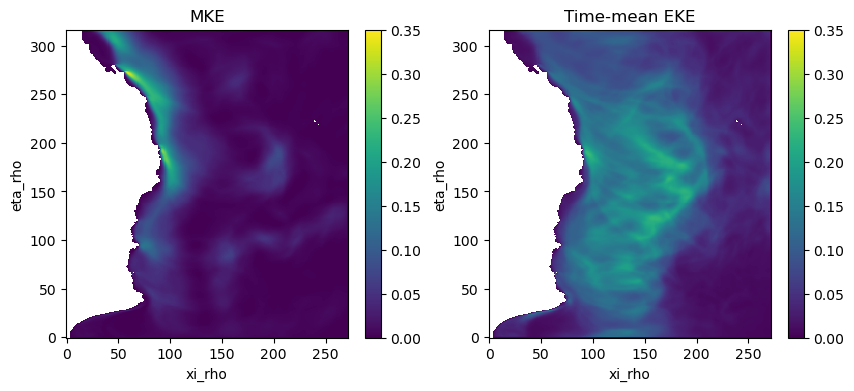

In [5]:
# Plotting

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
MKE.plot(ax=ax[0], vmax=0.35); ax[0].set_title('MKE')
EKE.plot(ax=ax[1], vmax=0.35); ax[1].set_title('Time-mean EKE');

### **Doing it seasonally**

In [6]:
# Grouping it by season and calculating the time-mean

u_season = u.groupby('ocean_time.season')
v_season = v.groupby('ocean_time.season')

# MKE
ubar_season = u_season.mean('ocean_time')
vbar_season = v_season.mean('ocean_time')

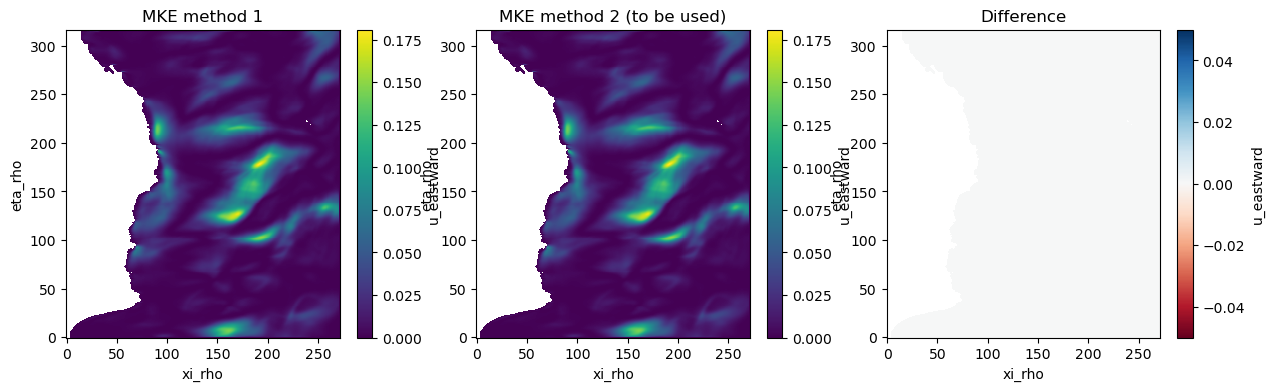

In [20]:
# Checking if I can perform the seasonal calculation without a loop
# Comparing if extracting the seasonal value gives me equal results as if not extracting

fig, ax = plt.subplots(ncols=3, figsize=(15, 4))

(ubar_season.sel(season='DJF')**2).plot(ax=ax[0]);ax[0].set_title('MKE method 1') 
(ubar_season**2).sel(season='DJF').plot(ax=ax[1]);ax[1].set_title('MKE method 2 (to be used)')
((ubar_season.sel(season='DJF')**2) - (ubar_season**2).sel(season='DJF')).plot(ax=ax[2], cmap='RdBu'); ax[2].set_title('Difference');

In [8]:
# Now I can calculate MKE by season as following

MKE_seasonal = 0.5 * (ubar_season**2 + vbar_season**2)


In [9]:
# Calculate seasonal EKE

uprime_season = u_season - ubar_season
vprime_season = v_season - vbar_season

EKE_season = 0.5 * (uprime_season**2 + vprime_season**2)

EKE_season_mean = EKE_season.groupby('season').mean('ocean_time')


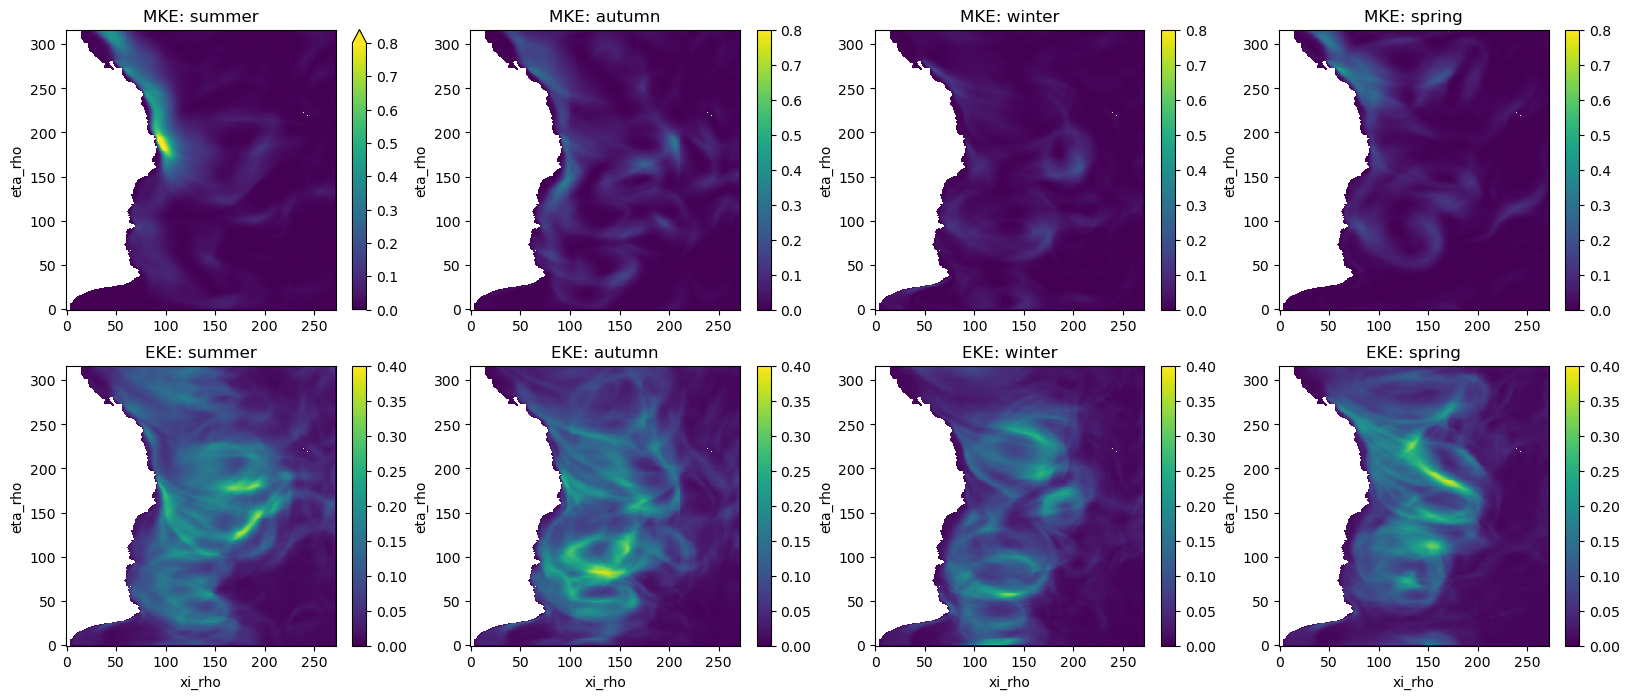

In [18]:
# Plotting SEASONAL

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 8))

MKE_seasonal.sel(season='DJF').plot(ax=ax[0, 0], vmax=0.8); ax[0, 0].set_title('MKE: summer')
MKE_seasonal.sel(season='MAM').plot(ax=ax[0, 1], vmax=0.8); ax[0, 1].set_title('MKE: autumn')
MKE_seasonal.sel(season='JJA').plot(ax=ax[0, 2], vmax=0.8); ax[0, 2].set_title('MKE: winter')
MKE_seasonal.sel(season='SON').plot(ax=ax[0, 3], vmax=0.8); ax[0, 3].set_title('MKE: spring')

EKE_season_mean.sel(season='DJF').plot(ax=ax[1, 0], vmax=0.4); ax[1, 0].set_title('EKE: summer')
EKE_season_mean.sel(season='MAM').plot(ax=ax[1, 1], vmax=0.4); ax[1, 1].set_title('EKE: autumn')
EKE_season_mean.sel(season='JJA').plot(ax=ax[1, 2], vmax=0.4); ax[1, 2].set_title('EKE: winter')
EKE_season_mean.sel(season='SON').plot(ax=ax[1, 3], vmax=0.4); ax[1, 3].set_title('EKE: spring')


# To avoid overlaying labels and titles
ax[0, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[0, 2].set_xlabel('')
ax[0, 3].set_xlabel('');

In [11]:
# Confirming that the method above is calculating correctly. 
# Doing more manually
uprime_season = u_season['DJF'] - ubar_season.sel(season='DJF')
vprime_season = v_season['DJF'] - vbar_season.sel(season='DJF')

eke_season = (0.5 * (uprime_season**2 + vprime_season**2)).mean('ocean_time')

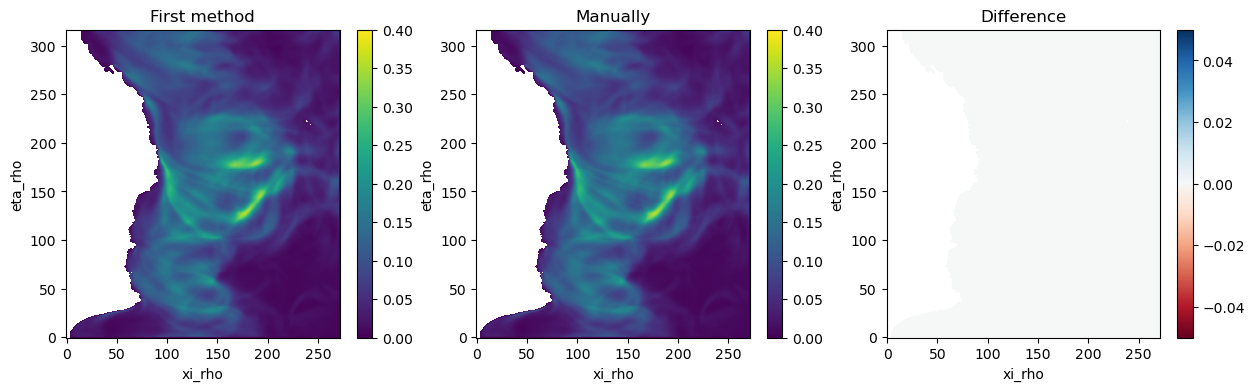

In [19]:
# Plotting the comparison

fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
EKE_season_mean.sel(season='DJF').plot(ax=ax[0], vmax=0.4); ax[0].set_title('First method')
eke_season.plot(ax=ax[1], vmax=0.4); ax[1].set_title('Manually')
(EKE_season_mean.sel(season='DJF') - eke_season).plot(ax=ax[2], cmap='RdBu'); ax[2].set_title('Difference');